# This notebook examines the effects of including increasing extrinsic mortality

# Imports

In [13]:
# Project setup and imports
import os, sys, random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from svgutils.compose import Figure, Panel, SVG
import pickle
from matplotlib import colors as mcolors
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
import functools  # Import functools to create a partial function
from scipy import interpolate
from lifelines import NelsonAalenFitter


# Locate project root and add to path
cwd = Path.cwd()
PROJECT_ROOT = next((p for p in [cwd, *cwd.parents] if (p / 'src').exists()), cwd)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Project-specific imports
from src.simulation import SR_sim
from src.plotting import SR_plotting
import src.sr_utils as utils
import src.correlation_analysis as ca
import src.twin_analysis as ta
import src.gamma_gompertz as gg
from src.HMD_lifetables import HMD
import saved_results.twin_studies_data as td
import saved_results.model_param_calibrations as pc

# Reproducibility setup
SEED = int(os.environ.get('PYTHONHASHSEED', '12345'))
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
RNG = np.random.default_rng(12345)

# Deterministic sampling helpers
def choice_deterministic(a, size=None, replace=True, p=None):
    return RNG.choice(a, size=size, replace=replace, p=p)

def rand_uniform(size=None):
    return RNG.random(size)

# Matplotlib configuration
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Plot styling
plt.rc('axes', facecolor='white', grid=False)
plt.rc('axes.spines', top=False, right=False)
plt.rc('font', size=16)
plt.rc('axes', titlesize=28, labelsize=24)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('xtick.major', size=8, width=2.5)
plt.rc('ytick.major', size=8, width=2.5)
plt.rc('xtick.minor', size=5, width=2.5)
plt.rc('ytick.minor', size=5, width=2.5)
plt.rc('legend', fontsize=16)
plt.rc('figure', titlesize=28)

def remove_top_right_spines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

# Jupyter extensions
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
sweden_cohort_f = HMD(country='swe', gender = 'female', data_type = 'cohort')
sweden_cohort_m = HMD(country='swe' , gender = 'male', data_type = 'cohort')
sweden_cohort_b = HMD(country='swe' , gender = 'both', data_type = 'cohort')

sweden_period_m = HMD(country='swe' , gender = 'male', data_type = 'period')
sweden_period_f = HMD(country='swe' , gender = 'female', data_type = 'period')

denmark_cohort_m = HMD(country='dan' , gender = 'male', data_type = 'cohort')
denmark_cohort_f = HMD(country='dan' , gender = 'female', data_type = 'cohort')
denmark_cohort_b = HMD(country='dan' , gender = 'both', data_type = 'cohort')


ages, avg_hazard, lower_hazard, upper_hazard = denmark_cohort_b.log_average_hazard_curve(years=np.arange(1870, 1901, 1))


years = np.arange(1870, 1901, 5)

# Rising extrinsic - same for all

### danish cohort simulation, constant h_ext for all

In [5]:
# Get SR parameters from model_param_calibrations
sr_params = pc.sr_calibrations['denmark']
sr_dict = pc.country_dicts['denmark']
n = int(1e5)

# Create MZ and DZ parameter distributions
dict_original = utils.create_param_distribution_dict(
    params_dict=sr_dict,
    params='Xc',
    std=sr_params['Xc_std'], 
    n=n,
    family='MZ'
)

# Create simulations for MZ and DZ twins
sim_original = utils.create_sr_simulation(
    params_dict=dict_original,
    parallel=True,
    tmax=140,
    n=n,
    h_ext=sr_params['m_ex'],
    break_early=True
)


plotter_original = SR_plotting(sim_original)


### rising extrinsic mortality, 85% gompertz slope

In [8]:

# Mask data for ages 30 to 100
mask = (ages >= 20) & (ages <= 100)
masked_ages = ages[mask]
masked_hazard = avg_hazard[mask]

# Define Gompertz function for fitting
def gompertz_log(t, m, a, b):
    return np.log(m + a * np.exp(b * t))

params, _ = curve_fit(gompertz_log, masked_ages, np.log(masked_hazard), 
                     p0=[0.001, 0.0001, 0.1], bounds=([0, 0, 0], [0.1, 0.1, 0.5]))

# Extract parameters
m_fit, a_fit, b_fit = params
print(f"Fitted parameters: m={m_fit:.6e}, a={a_fit:.6e}, b={b_fit:.6e}")

# Use the baseline m_ex from pc.sr_calibrations['denmark']
baseline_m_ex = pc.sr_calibrations['denmark']['m_ex']
print(baseline_m_ex)

dict = pc.sr_denmark_dict.copy()
dict['beta'] = 1.03*dict['beta']
dict['Xc'] = 1.1*dict['Xc']

# Create parameter distributions for this sim
sr_dict_custom = utils.create_param_distribution_dict(
    params_dict=dict,
    params='Xc',
    std=sr_params['Xc_std'], 
    n=int(1e5),
    family='MZ'
)
scale = 0.85

gompertz_hazard_partial = functools.partial(utils.gompertz_hazard, m=baseline_m_ex, a=a_fit, b=scale*b_fit)

# Run simulation with the custom hazard function
sim_custom = utils.create_sr_simulation(
    params_dict=sr_dict_custom,
    parallel=True,
    tmax=140,
    n=int(1e5),
    h_ext=gompertz_hazard_partial,
    break_early=True
)

plotter_custom = SR_plotting(sim_custom)
# Calculate correlation for the custom hazard function
correlation_custom = ca.calc_pearson_corr_twin_deaths(sim_custom, filter_age=15)
print(f"Custom hazard with baseline m_ex={baseline_m_ex:.6e}, correlation={correlation_custom:.4f}")

Fitted parameters: m=3.643782e-03, a=3.444882e-05, b=9.743133e-02
0.003
Custom hazard with baseline m_ex=3.000000e-03, correlation=0.1151


Text(0.5, 1.0, 'Correlation for increasing extrinsic mortality = 0.12')

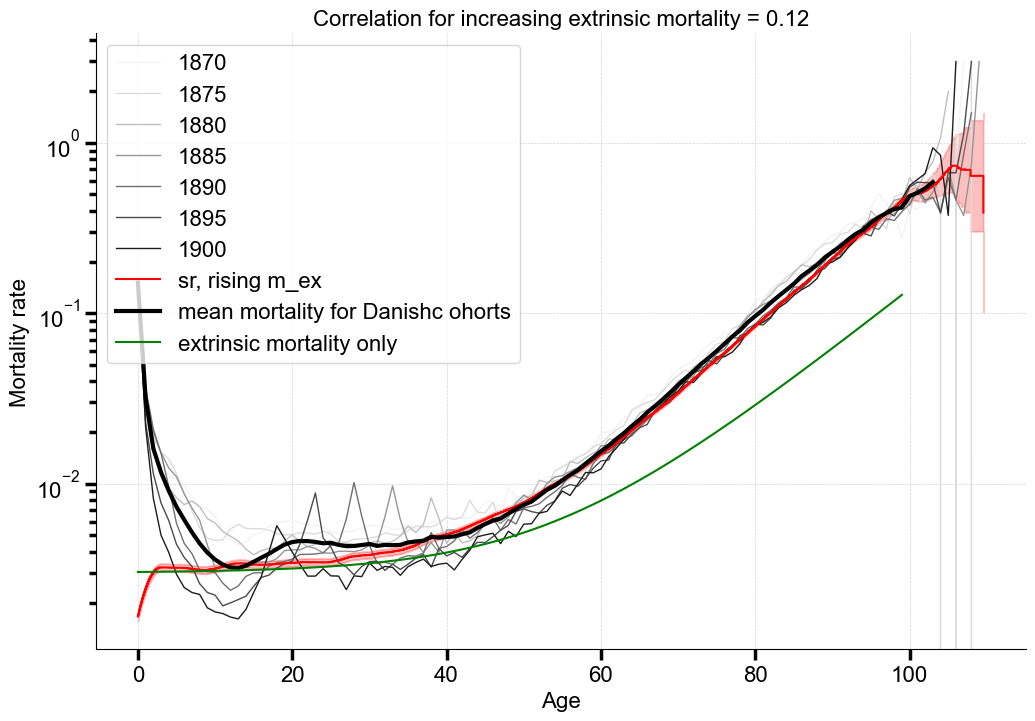

In [10]:
fig, ax = plt.subplots(1,1, figsize=(12,8))



denmark_cohort_b.plot_hazard(years = [1870, 1875, 1880, 1885, 1890, 1895, 1900], ax = ax, linewidth = 1, cmap = 'Greys')
# plotter_original.plot_hazard(ax=ax, color = 'blue', label = 'sr, constant m_ex')
plotter_custom.plot_hazard(ax=ax, color = 'red', label = 'sr, rising m_ex')

ax.plot(ages,avg_hazard, color = 'black', linewidth = 3, label = 'mean mortality for Danishc ohorts')

ax.plot(np.arange(100), gompertz_hazard_partial(np.arange(100)), color = 'green', label = 'extrinsic mortality only')


ax.legend()
ax.set_xlabel('Age', fontname='Arial', fontsize = 16)
ax.set_ylabel('Mortality rate', fontname='Arial', fontsize = 16)
ax.set_title(f'Correlation for increasing extrinsic mortality = {round(correlation_custom, 2)}', fontname='Arial', fontsize = 16)



### correlation for increasing extrinisc mortality is lower! we now get $r_{MZ} \approx 0.12$ with the same amount of Xc variation, meaning we need to increase Xc variation

# we're going to do the following:

1. calc gompertz slopes for diff Xc values. Get an interpolating function slope(Xc).
2. for each Xc value individual we'll give his/her own rising extrinsic mortality based on his/her Xc, reflecting his/her own loss of resilience. 
3. recalculate correlations

In [11]:
# Get SR parameters from model_param_calibrations
sr_params = pc.sr_calibrations['denmark']
sr_dict = pc.country_dicts['denmark']
n = int(3e5)

# Create MZ and DZ parameter distributions
dict_original = utils.create_param_distribution_dict(
    params_dict=sr_dict,
    params='Xc',
    std=sr_params['Xc_std'], 
    n=n,
    family='None'
)

# Create simulations for MZ and DZ twins
sim_original = utils.create_sr_simulation(
    params_dict=dict_original,
    parallel=True,
    tmax=140,
    n=n,
    h_ext=None,
    break_early=True
)



### stratifying according to Xc groups, and calculating their intrinsic slope and intercept

In [15]:
# Get Xc values and divide into 30 equally spaced bins
sim = sim_original
death_times = sim.death_times[sim.death_times > 20]

xc_values = sim.params.Xc[sim.death_times > 20]
# Get min and max values of Xc
xc_min = xc_values.min()
xc_max = xc_values.max()

# Create 20 evenly spaced bins
n_bins = 20
bin_edges = np.linspace(xc_min, xc_max, n_bins + 1)  # 21 edges to create 20 bins
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Initialize arrays to store results
xc_means = []
gompertz_slopes = []
intercepts = []

# Loop over each bin
for i in range(n_bins-2):
    # Find indices for this bin
    bin_mask = (xc_values >= bin_edges[i]) & (xc_values < bin_edges[i+1])
    # For the last bin, include the upper edge
    if i == n_bins - 1:
        bin_mask = (xc_values >= bin_edges[i]) & (xc_values <= bin_edges[i+1])
    
    bin_indices = np.where(bin_mask)[0]
    
    # Skip if bin is empty
    if len(bin_indices) == 0:
        continue
    
    # Get death times for this bin
    death_times_bin = death_times[bin_indices]
    
    # Create Nelson-Aalen fitter
    naf = NelsonAalenFitter()
    naf.fit(death_times_bin, event_observed=np.ones(len(death_times_bin)))
    
    # Get hazard data
    time_array = naf.timeline
    hazard_array = naf.smoothed_hazard_(bandwidth = 3).values
    
    # Filter to age range 20-100
    age_mask = (time_array >= 20) & (time_array <= 100)
    time_array_filtered = time_array[age_mask]
    hazard_array_filtered = hazard_array[age_mask]
    
    # Convert to log10 scale for fitting
    log10_hazard_array_filtered = np.log10(hazard_array_filtered).flatten()
    
    # Fit the Gamma-Gompertz model
    print(i)
    gg_model = gg.GammaGompertz() 
    gg_model.fit_params(time_array=time_array_filtered, log10_hazard_array=log10_hazard_array_filtered,print_out=False)
    
    # Store results
    xc_means.append(bin_centers[i])
    gompertz_slopes.append(gg_model.b)
    intercepts.append(np.log10(gg_model.a))



0
1
2
3


/Users/benshenhar/Library/CloudStorage/GoogleDrive-benshenhar@gmail.com/My Drive/Weizmann/Alon Lab/my papers/extrinsic mortality/code/src/gamma_gompertz.py:244: RuntimeWarning: overflow encountered in exp
  exp_c = np.exp(c)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


4
5
6
7
8
9
10
11
12
13
14
15
16
17


### creating interpolation functions to convert Xc to intercept and slope

Start index: 3, Xc value: 10.497031455963775
End index: 13, Xc value: 25.212657552991224


/var/folders/r5/2q8zzrr15ld3_jcs6mjrvk900000gn/T/ipykernel_90444/2941330347.py:56: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/r5/2q8zzrr15ld3_jcs6mjrvk900000gn/T/ipykernel_90444/2941330347.py:56: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


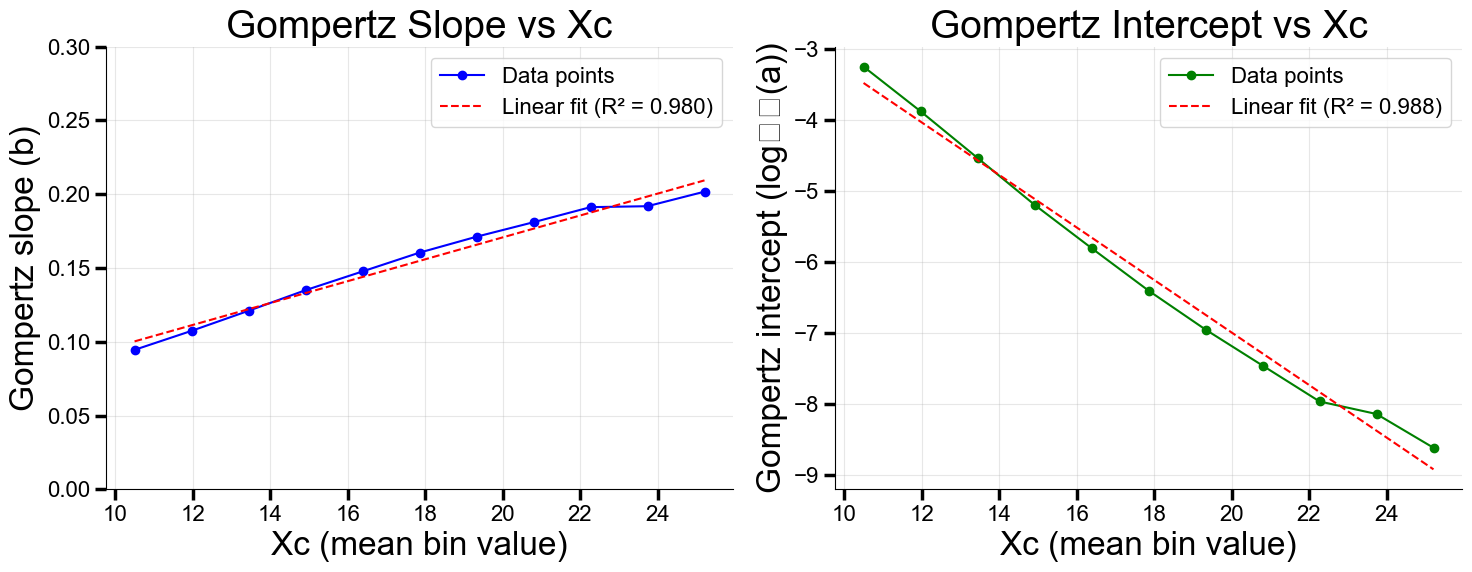

Slope fit: slope = 0.007410, intercept = 0.022505, R² = 0.980
Intercept fit: slope = -0.370468, intercept = 0.413622, R² = 0.988


In [16]:
    
# Find indices closest to 10 and 24.5
start_ind = np.argmin(np.abs(np.array(xc_means) - 10))
end_ind = np.argmin(np.abs(np.array(xc_means) - 24.5))

print(f"Start index: {start_ind}, Xc value: {xc_means[start_ind]}")
print(f"End index: {end_ind}, Xc value: {xc_means[end_ind]}")

# Plot Gompertz slope and intercept vs Xc mean
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Left subplot: Gompertz slope vs Xc
ax1.plot(xc_means[start_ind:end_ind+1], gompertz_slopes[start_ind:end_ind+1], 'o-', color='blue', label='Data points')

ax1.set_xlabel('Xc (mean bin value)', fontname='Arial')
ax1.set_ylabel('Gompertz slope (b)', fontname='Arial')
ax1.set_title('Gompertz Slope vs Xc', fontname='Arial')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 0.3)

# Right subplot: Gompertz intercept vs Xc
ax2.plot(xc_means[start_ind:end_ind+1], intercepts[start_ind:end_ind+1], 'o-', color='green', label='Data points')

ax2.set_xlabel('Xc (mean bin value)', fontname='Arial')
ax2.set_ylabel('Gompertz intercept (log₁₀(a))', fontname='Arial')
ax2.set_title('Gompertz Intercept vs Xc', fontname='Arial')
ax2.grid(True, alpha=0.3)

# Now perform regressions and add fits
from scipy.stats import linregress

# Fit a straight line for slope (using start_ind to end_ind)
slope_slope, slope_intercept, slope_r_value, slope_p_value, slope_std_err = linregress(xc_means[start_ind:end_ind+1], gompertz_slopes[start_ind:end_ind+1])

# Fit a straight line for intercept (using start_ind to end_ind)
intercept_slope, intercept_intercept, intercept_r_value, intercept_p_value, intercept_std_err = linregress(xc_means[start_ind:end_ind+1], intercepts[start_ind:end_ind+1])

# Create interpolating functions
from scipy.interpolate import interp1d
xc_to_slope = interp1d(xc_means[start_ind:end_ind+1], gompertz_slopes[start_ind:end_ind+1], kind='linear', 
                       bounds_error=False, fill_value='extrapolate')
xc_to_intercept = interp1d(xc_means[start_ind:end_ind+1], intercepts[start_ind:end_ind+1], kind='linear', 
                          bounds_error=False, fill_value='extrapolate')

# Add fits to existing axes
# Plot the fitted line for slope
x_fit = np.linspace(min(xc_means[start_ind:end_ind+1]), max(xc_means[start_ind:end_ind+1]), 100)
y_fit_slope = slope_slope * x_fit + slope_intercept
ax1.plot(x_fit, y_fit_slope, '--', color='red', label=f'Linear fit (R² = {slope_r_value**2:.3f})')
ax1.legend()

# Plot the fitted line for intercept
y_fit_intercept = intercept_slope * x_fit + intercept_intercept
ax2.plot(x_fit, y_fit_intercept, '--', color='red', label=f'Linear fit (R² = {intercept_r_value**2:.3f})')
ax2.legend()

plt.tight_layout()
plt.show()

# Print the linear fit parameters
print(f"Slope fit: slope = {slope_slope:.6f}, intercept = {slope_intercept:.6f}, R² = {slope_r_value**2:.3f}")
print(f"Intercept fit: slope = {intercept_slope:.6f}, intercept = {intercept_intercept:.6f}, R² = {intercept_r_value**2:.3f}")


### creating with changing h_ext for each (and slightly adjusted baseline params)

In [17]:
# Get SR parameters from model_param_calibrations
sr_params = pc.sr_calibrations['denmark']
sr_dict = pc.country_dicts['denmark']
n = int(1e5)
# Use the baseline m_ex from pc.sr_calibrations['denmark']
baseline_m_ex = pc.sr_calibrations['denmark']['m_ex']


# Create MZ and DZ parameter distributions
dict_original = utils.create_param_distribution_dict(
    params_dict=sr_dict,
    params='Xc',
    std=sr_params['Xc_std'], 
    n=n,
    family='MZ'
)

dict_original['beta'] = 1.03*dict_original['beta']
dict_original['Xc'] = 1.05*dict_original['Xc']
dict_original['eta'] = 1.03*dict_original['eta']

scale = 0.785
# Create array of partial functions based on Xc values - optimized for speed
xc_values = dict_original['Xc']
# Vectorized computation of a and b values
a_vals = 10**xc_to_intercept(xc_values)
b_vals = scale * xc_to_slope(xc_values)
# Create partial functions using list comprehension for speed
gompertz_hazard_partials = [
    functools.partial(utils.gompertz_hazard, m=baseline_m_ex, a=a_val, b=b_val)
    for a_val, b_val in zip(a_vals, b_vals)
]

    

In [18]:

# Create simulations for MZ and DZ twins
sim_custom_h_ext = utils.create_sr_simulation(
    params_dict=dict_original,
    parallel=True,
    tmax=140,
    n=n,
    h_ext=gompertz_hazard_partials,
    break_early=True
)

correlation_custom = ca.calc_pearson_corr_twin_deaths(sim_custom_h_ext, filter_age=15)
print(correlation_custom)


0.21634615558634349


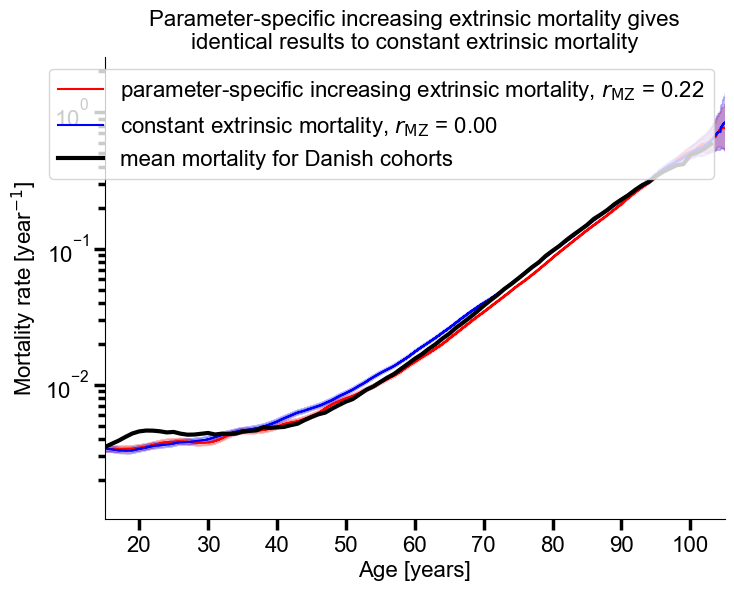

In [19]:
correlation_original = ca.calc_pearson_corr_twin_deaths(sim_original, filter_age=15)
plotter_increasing_extrinsic = SR_plotting(sim_custom_h_ext)
fig, ax = plt.subplots(figsize=(8, 6))
# Set Arial font for all text in the plot
plt.rcParams['font.family'] = 'Arial'
plotter_increasing_extrinsic.plot_hazard(ax=ax, color='red', label=fr'parameter-specific increasing extrinsic mortality, $r_{{\mathrm{{MZ}}}}$ = {correlation_custom:.2f}')
plotter_original.plot_hazard(ax=ax, color='blue', label=fr'constant extrinsic mortality, $r_{{\mathrm{{MZ}}}}$ = {correlation_original:.2f}')
ax.plot(ages, avg_hazard, color='black', linewidth=3, label='mean mortality for Danish cohorts')

ax.set_xlabel('Age [years]', fontsize=16)
ax.set_ylabel(r'Mortality rate [year$^{-1}$]', fontsize=16)
ax.set_title(f'Parameter-specific increasing extrinsic mortality gives\nidentical results to constant extrinsic mortality', fontsize=16)
ax.set_yscale('log')
ax.set_xlim(15, 105)
ax.grid(False)
ax.legend()
plt.show()

In [21]:
# Load all mortality data
extrinsic_females = pd.read_csv(os.path.join(PROJECT_ROOT, 'saved_data', 'extrinsic_females_carnes.csv'), header=None)
intrinsic_females = pd.read_csv(os.path.join(PROJECT_ROOT, 'saved_data', 'intrinsic_females_carnes.csv'), header=None)
total_females = pd.read_csv(os.path.join(PROJECT_ROOT, 'saved_data', 'total_females_carnes.csv'), header=None)

# Create age array from 0 to 100 in steps of 1
ages = np.arange(18, 100, 1)

# Interpolate log hazard rates onto common age array
logh_extrinsic = interpolate.interp1d(extrinsic_females[0].values, extrinsic_females[1].values, bounds_error=False)(ages)
logh_intrinsic = interpolate.interp1d(intrinsic_females[0].values, intrinsic_females[1].values, bounds_error=False)(ages)
logh_total = interpolate.interp1d(total_females[0].values, total_females[1].values, bounds_error=False)(ages)

# Calculate hazard rates from log hazard rates
h_extrinsic_females = 10**logh_extrinsic
h_intrinsic_females = 10**logh_intrinsic
h_total_females = 10**logh_total

extrinsic_males = pd.read_csv(os.path.join(PROJECT_ROOT, 'saved_data', 'extrinsic_males_carnes.csv'), header=None)
intrinsic_males = pd.read_csv(os.path.join(PROJECT_ROOT, 'saved_data', 'intrinsic_males_carnes.csv'), header=None)
total_males = pd.read_csv(os.path.join(PROJECT_ROOT, 'saved_data', 'total_males_carnes.csv'), header=None)

logh_extrinsic = interpolate.interp1d(extrinsic_males[0].values, np.log10(extrinsic_males[1].values), bounds_error=False)(ages)
logh_intrinsic = interpolate.interp1d(intrinsic_males[0].values, np.log10(intrinsic_males[1].values), bounds_error=False)(ages)
logh_total = interpolate.interp1d(total_males[0].values, np.log10(total_males[1].values), bounds_error=False)(ages)

h_extrinsic_males = 10**logh_extrinsic
h_intrinsic_males = 10**logh_intrinsic
h_total_males = 10**logh_total


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Female Gompertz slope ratio, extrinsic/intrinsic:  0.7879276242474471


/var/folders/r5/2q8zzrr15ld3_jcs6mjrvk900000gn/T/ipykernel_18180/611636191.py:161: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


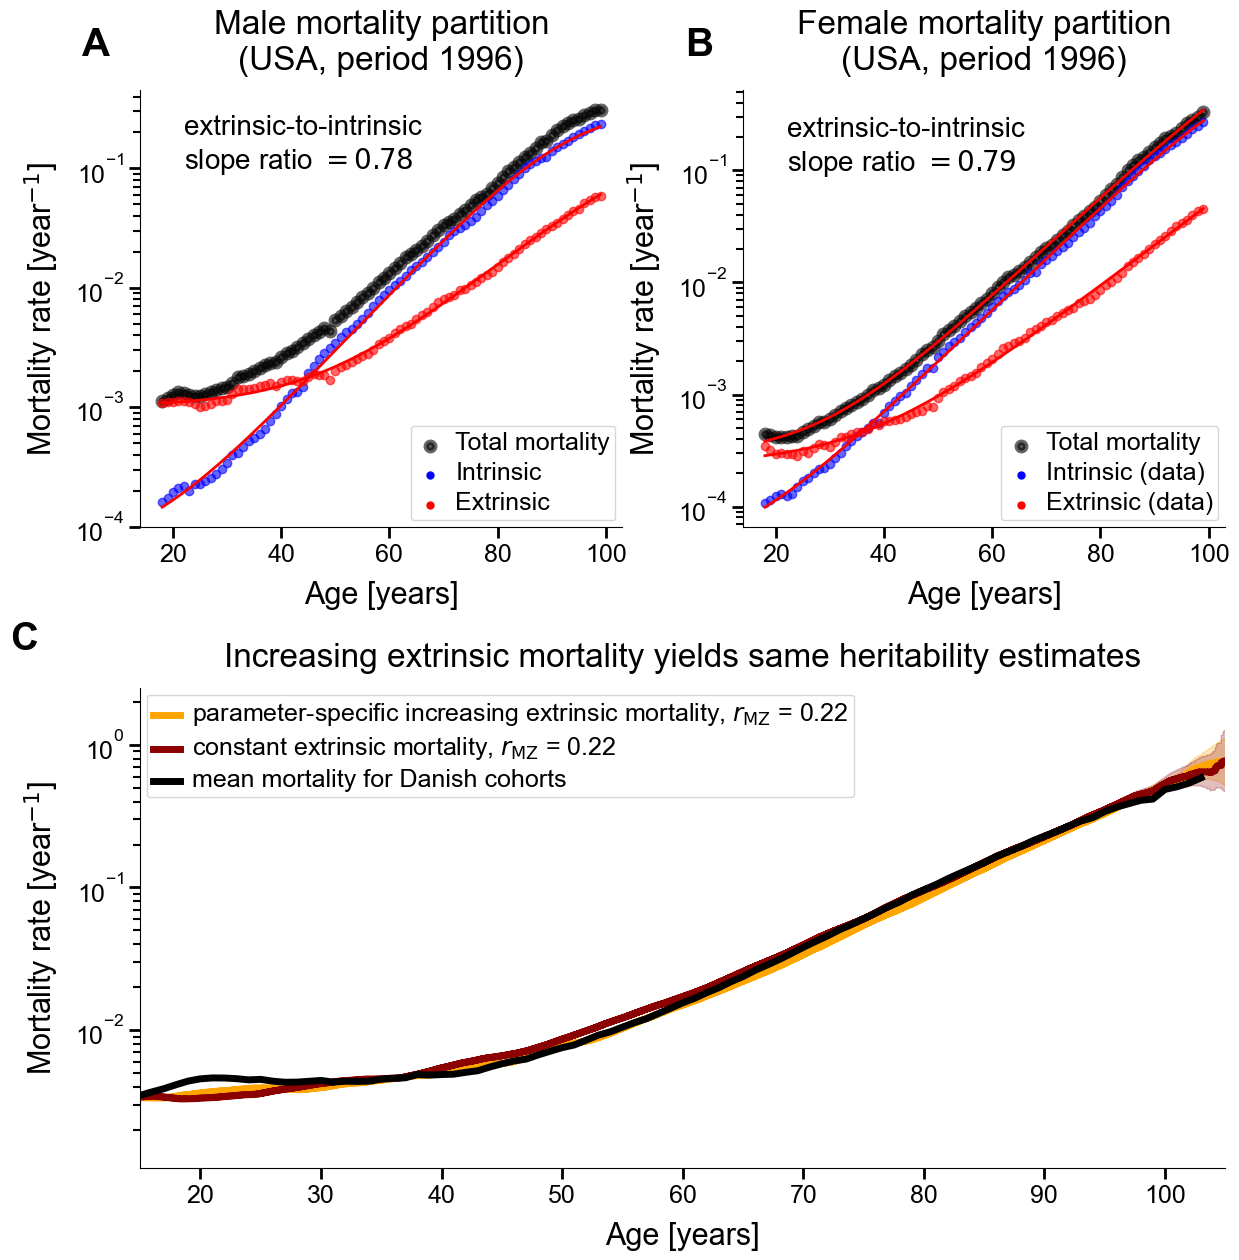

In [ ]:
# Create a 2x2 grid, with the bottom row spanning both columns
from matplotlib.gridspec import GridSpec

plt.rcParams['font.family'] = 'Arial'

fig = plt.figure(figsize=(14, 14))
gs = GridSpec(2, 2, height_ratios=[1, 1.1], hspace=0.35, wspace=0.25)

# Top left: Male mortality partition
ax1 = fig.add_subplot(gs[0, 0])

# --- MALES ---
# Fit models
male_total_model = gg()
male_total_model.fit_params(time_array=ages, log10_hazard_array=np.log10(h_total_males), print_out=False)
male_intrinsic_model = gg()
male_intrinsic_model.fit_params(time_array=ages, log10_hazard_array=np.log10(h_intrinsic_males), print_out=False)
male_extrinsic_model = gg()
male_extrinsic_model.fit_params(time_array=ages, log10_hazard_array=np.log10(h_extrinsic_males), print_out=False)

# Plot total mortality as black dots and as a thick black line (fit)
male_total_model.plot_hazard_with_array_comparison(
    ages, np.log10(h_total_males), ax=ax1, label='Total mortality', plot_model=False, color='black', linestyle='-', linewidth=4
)

# Plot intrinsic mortality as blue dots and fit
ax1.plot(ages, np.log10(h_intrinsic_males), 'o', color='blue', label='Intrinsic', markersize=5)
male_intrinsic_model.plot_hazard_with_array_comparison(
    ages, np.log10(h_intrinsic_males), ax=ax1, label=None, color='blue', linestyle='-'
)

# Plot extrinsic mortality as red dots and fit
ax1.plot(ages, np.log10(h_extrinsic_males), 'o', color='red', label='Extrinsic', markersize=5)
male_extrinsic_model.plot_hazard_with_array_comparison(
    ages, np.log10(h_extrinsic_males), ax=ax1, label=None, color='red', linestyle='-'
)

# Slope ratio between extrinsic and intrinsic
slope_ratio_male = male_extrinsic_model.b / male_intrinsic_model.b
ax1.text(
    22, 0.1, r'extrinsic-to-intrinsic' + '\n' + r'slope ratio $= {:.2f}$'.format(slope_ratio_male),
    fontsize=20, fontfamily='Arial'
)

ax1.set_xlabel('Age [years]', fontsize=22, fontfamily='Arial', labelpad=10)
ax1.set_ylabel('Mortality rate [year$^{-1}$]', fontsize=22, fontfamily='Arial', labelpad=10)
ax1.tick_params(axis='both', which='major', labelsize=18, length=8, width=2)
ax1.tick_params(axis='both', which='minor', labelsize=16, length=5, width=1.5)
leg1 = ax1.get_legend()
if leg1 is not None:
    for text in leg1.get_texts():
        text.set_fontfamily('Arial')
        text.set_fontsize(18)
ax1.set_title('Male mortality partition\n(USA, period 1996)', fontsize=24, fontfamily='Arial', pad=15)

# Top right: Female mortality partition
ax2 = fig.add_subplot(gs[0, 1])

# --- FEMALES ---
# Fit models
female_total_model = gg()
female_total_model.fit_params(time_array=ages, log10_hazard_array=np.log10(h_total_females), print_out=False)
female_intrinsic_model = gg()
female_intrinsic_model.fit_params(time_array=ages, log10_hazard_array=np.log10(h_intrinsic_females), print_out=False)
female_extrinsic_model = gg()
female_extrinsic_model.fit_params(time_array=ages, log10_hazard_array=np.log10(h_extrinsic_females), print_out=False)

# Plot total mortality as black dots and as a thick black line (fit)
female_total_model.plot_hazard_with_array_comparison(
    ages, np.log10(h_total_females), ax=ax2, label='Total mortality', color='black', linestyle='-', linewidth=4
)

# Plot intrinsic mortality as blue dots and fit
ax2.plot(ages, np.log10(h_intrinsic_females), 'o', color='blue', label='Intrinsic (data)', markersize=5)
female_intrinsic_model.plot_hazard_with_array_comparison(
    ages, np.log10(h_intrinsic_females), ax=ax2, label=None, color='blue', linestyle='-'
)

# Plot extrinsic mortality as red dots and fit
ax2.plot(ages, np.log10(h_extrinsic_females), 'o', color='red', label='Extrinsic (data)', markersize=5)
female_extrinsic_model.plot_hazard_with_array_comparison(
    ages, np.log10(h_extrinsic_females), ax=ax2, label=None, color='red', linestyle='-',
)

# Slope ratio between extrinsic and intrinsic
slope_ratio_female = female_extrinsic_model.b / female_intrinsic_model.b
print('Female Gompertz slope ratio, extrinsic/intrinsic: ', slope_ratio_female)
ax2.text(
    22, 0.1, r'extrinsic-to-intrinsic' + '\n' + r'slope ratio $= {:.2f}$'.format(slope_ratio_female),
    fontsize=20, fontfamily='Arial'
)

ax2.set_xlabel('Age [years]', fontsize=22, fontfamily='Arial', labelpad=10)
ax2.set_ylabel('Mortality rate [year$^{-1}$]', fontsize=22, fontfamily='Arial', labelpad=10)
ax2.tick_params(axis='both', which='major', labelsize=18, length=8, width=2)
ax2.tick_params(axis='both', which='minor', labelsize=16, length=5, width=1.5)
leg2 = ax2.get_legend()
if leg2 is not None:
    for text in leg2.get_texts():
        text.set_fontfamily('Arial')
        text.set_fontsize(18)
ax2.set_title('Female mortality partition\n(USA, period 1996)', fontsize=24, fontfamily='Arial', pad=15)

# Bottom row: Hazard comparison plot spanning both columns
ax3 = fig.add_subplot(gs[1, :])

t_vec, avg_hazard, lower_hazard, upper_hazard = denmark_cohort_b.log_average_hazard_curve(years=np.arange(1870, 1901, 1))

correlation_original = ca.calc_pearson_corr_twin_deaths(sim_original, filter_age=15)
linewidth_hazard = 5

# Use different colors (not red and blue) for the two simulation lines
color_constant_extrinsic = '#8B0000'  # dark crimson red
color_increasing_extrinsic = 'orange'

plotter_increasing_extrinsic = SR_plotting(sim_custom_h_ext)
# Set Arial font for all text in the plot
plotter_increasing_extrinsic.plot_hazard(
    ax=ax3, color=color_increasing_extrinsic, 
    label=fr'parameter-specific increasing extrinsic mortality, $r_{{\mathrm{{MZ}}}}$ = {correlation_custom:.2f}',
    linewidth=linewidth_hazard
)
plotter_original.plot_hazard(
    ax=ax3, color=color_constant_extrinsic, 
    label=fr'constant extrinsic mortality, $r_{{\mathrm{{MZ}}}}$ = {correlation_original:.2f}',
    linewidth=linewidth_hazard
)

# Plot mean mortality for Danish cohorts and keep the handle for legend
line_mean, = ax3.plot(
    t_vec, avg_hazard, color='black', linewidth=linewidth_hazard, label='mean mortality for Danish cohorts'
)

# Set axis labels, ticks, and title formatting to match top subplots
ax3.set_xlabel('Age [years]', fontsize=22, fontfamily='Arial', labelpad=10)
ax3.set_ylabel('Mortality rate [year$^{-1}$]', fontsize=22, fontfamily='Arial', labelpad=10)
ax3.tick_params(axis='both', which='major', labelsize=18, length=8, width=2)
ax3.tick_params(axis='both', which='minor', labelsize=16, length=5, width=1.5)
ax3.set_title('Increasing extrinsic mortality yields same heritability estimates', fontsize=24, fontfamily='Arial', pad=15)
ax3.set_yscale('log')
ax3.set_xlim(15, 105)
ax3.grid(False)

# Explicitly set the legend with all handles to ensure all lines are included
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles, labels)

leg3 = ax3.get_legend()
if leg3 is not None:
    for text in leg3.get_texts():
        text.set_fontfamily('Arial')
        text.set_fontsize(18)

# Add panel labels A, B, C to the three axes
def add_panel_labels(axs, labels, x=-0.1, y=1.1, fontsize=60):
    for ax, lab in zip(axs, labels):
        ax.text(x, y, lab, transform=ax.transAxes, fontsize=fontsize, fontweight='bold', fontfamily='Arial')

add_panel_labels([ax1, ax2, ax3], ['A', 'B', 'C'], x=-0.12, y=1.08, fontsize=28)

fig.tight_layout()
plt.show()
